In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
% matplotlib inline
from src.importance_and_dependence import (MyRandomForestClassifier,
                                       MyRandomForestRegressor,
                                       my_oob_permutation_importance,
                                       partial_dependence,
                                       partial_dependence_2d,
                                       replace_column)


In [2]:
df_train = pd.read_csv('data/churn_train.csv', parse_dates=['last_trip_date', 'signup_date'])
df_test = pd.read_csv('data/churn_test.csv', parse_dates=['last_trip_date', 'signup_date'])
df_tot = pd.read_csv('data/churn.csv', parse_dates=['last_trip_date', 'signup_date'])
cutoff = cutoff = df_tot.last_trip_date.max() - pd.to_timedelta(30,'D')

In [3]:

def get_feature_names(df, target):
    df = df.copy()
    #categorical variable dummying 
    cats = ['city', 'phone']
    for cat in cats:
        temp = pd.get_dummies(df, drop_first=False, columns=[cat])
        df[temp.columns] = temp
    df = df.drop(columns=cats, axis = 1)
    ## change boolean column to numerical for means
    df['luxury_car_user'] = df['luxury_car_user'].astype('float64')
    
    ## split datetime objects into multiple columns
    date_object = [ 'signup_date']
    for col in date_object:
        month_col = col + '_month'
        df[month_col] = df[col].apply( lambda x: x.month)
        day_col = col + '_day'
        df[day_col] = df[col].apply( lambda x: x.day)
        year_col = col + '_year'
        df[year_col] = df[col].apply( lambda x: x.year)
    df = df.drop(columns=date_object, axis = 1 )
    
    #get columns and remove target and create impute columns
    columns = list(df.columns)
    columns.remove(target)
    space = len(columns) #index for when imputing columns start
    impute_columns = list(map(lambda x: x + '_imputed', columns))
    df[impute_columns] = pd.DataFrame(np.zeros((df.shape[0], len(impute_columns))))
    columns += impute_columns
    return df.mean(), columns, space
    

In [4]:
def transform_frame(df, target, means, cols, space, cutoff):
    df = df.copy()
    ## gets the target
    y =  df.pop(target) <= cutoff
   
    ##transforms the frame
    date_object = ['signup_date']
    for col in date_object:
        month_col = col + '_month'
        df[month_col] = df[col].apply( lambda x: x.month)
        day_col = col + '_day'
        df[day_col] = df[col].apply( lambda x: x.day)
        year_col = col + '_year'
        df[year_col] = df[col].apply( lambda x: x.year)
    df = df.drop(columns=date_object, axis = 1 )
    
    new_df = pd.DataFrame(columns=cols)
    df_columns = list(df.columns)
    new_frame = np.zeros((df.shape[0],len(cols)))
    for index, row in df.iterrows():
        new_row = np.zeros(len(cols))
        for i, col in enumerate(cols):
            split = col.split("_")[0]
            cat = split[0]
            entry = ''.join(split[1:])
            if "impute" in col:
                break
            elif col in df_columns and not np.isnan(row[col]):
                new_row[i] = row[col]
            elif  cat in df_columns and row[cat] == entry:
                new_row[i] = 1
            else:
                new_row[i] = means[i]
                new_row[i + space] = 1
        new_frame[index] = new_row
    
    return pd.DataFrame(new_frame, columns = cols), y

In [5]:
def ezprint_cmatrix(ytrue, yhat):
    print("Precision: ", precision_score(ytrue, yhat))
    print("Recall: ", recall_score(ytrue, yhat))
    print("Accuracy score", accuracy_score(ytrue, yhat))
    
def specificity_score(y_true, y_pred):
    TN = len(y_true[y_true == y_pred and y_true == False])
    FP = len(y_true[y_true != y_pred and y_true == False])
    return TN / (TN + FP)

In [6]:
def partial_dependence(model, X, feature_index, classification=True):
    '''
    Parameters
    ----------
    model: fitted model
        anything with .predict()
    X: numpy array
        data the model was trained on.
    feature_index: int
        feature to calculate partial dependence for
    classification: boolean. 
        True if the model is a classifier
           (in which case, it must have .predict_proba()
        False if the model is a regressor
        
    Returns
    -------
    x_values: numpy array
        x values to plot partial dependence over
    pdp: numpy array
        partial dependence values
        
    example:
    >> x, pdp = partial_dependece(model, X_train, 3, classification=False)
    >> plt.plot(x, pdp)
    '''
    
    x_values = np.unique(X[:,feature_index])
    pdp = np.zeros(x_values.shape)
    for i, value in enumerate(x_values):
        X_new = replace_column(X, feature_index, value)
        if classification:
            y_pred_prob = model.predict_proba(X_new)[:,1]
            y_pred_prob = np.clip(y_pred_prob, 0.001, 0.999)
            y_pred = np.log(y_pred_prob / (1 - y_pred_prob))
        else:
            y_pred = model.predict(X_new)
        pdp[i] = y_pred.mean()
    return (x_values, pdp)
        
    
def partial_dependence_2d(model, X, feature_index_1, feature_index_2, classification=True):
    '''
    see docstring for partial_dependence.
    this takes two feature indices and calculates
    the joint partial dependence
    
    example:
    >> from mpl_toolkits.mplot3d import Axes3D
    >> xx1, xx2, pdp2d = partial_dependence_2d(mod, X_train, 5, 12)
    >> fig = plt.figure()
    >> ax = Axes3D(fig)
    >> ax.plot_surface(xx1, xx2, pdp2d)
    '''
    
    x1_values = np.unique(X[:,feature_index_1])
    x2_values = np.unique(X[:,feature_index_2])
    pdp = np.zeros((len(x1_values), len(x2_values)))
    for i, val1 in enumerate(x1_values):
        for j, val2 in enumerate(x2_values):
            X_new = replace_column(X, feature_index_1, val1)
            X_new = replace_column(X_new, feature_index_2, val2)
            if classification:
                y_pred_prob = model.predict_proba(X_new)[:,1]
                y_pred_prob = np.clip(y_pred_prob, 0.001, 0.999)
                y_pred = np.log(y_pred_prob / (1 - y_pred_prob))
            else:
                y_pred = model.predict(X_new)
            pdp[i,j] = y_pred.mean()
    xx1, xx2  = np.meshgrid(x1_values, x2_values, indexing='ij')
    return (xx1, xx2, pdp)
        

# Getting test and train data and handle missing data

In [7]:
target = 'last_trip_date'
means, cols, spaces = get_feature_names(df_train, target)
#new_df, target = transform_frame(df_train, target, means, cols, spaces, cutoff)
train_X, train_y = transform_frame(df_train, target, means, cols, spaces, cutoff)
test_X, test_y = transform_frame(df_test, target, means, cols, spaces, cutoff)

# Run the algorithm

In [8]:
rf = RandomForestClassifier(class_weight='balanced')
model = rf.fit(train_X, train_y)
yhat = model.predict(test_X)
ezprint_cmatrix(test_y, yhat)
#ezprint_cmatrix(test_y, np.ones((len(yhat), 1)))

Precision:  0.7707332692923471
Recall:  0.7611067193675889
Accuracy score 0.7057


# Plot the feature importance

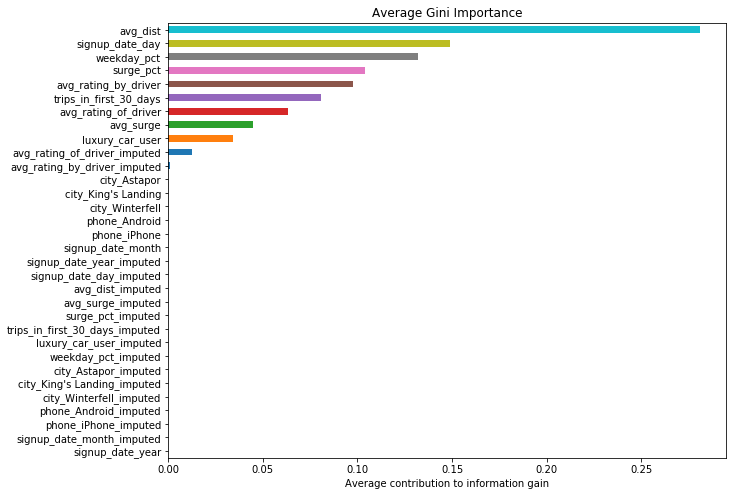

In [9]:

# Plot the feature importance
feat_scores = pd.Series(rf.feature_importances_,
                           index=train_X.columns)
feat_scores = feat_scores.sort_values()
ax = feat_scores.plot(kind='barh', figsize=(10,8))
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain');

In [10]:
len(train_X.columns)

32

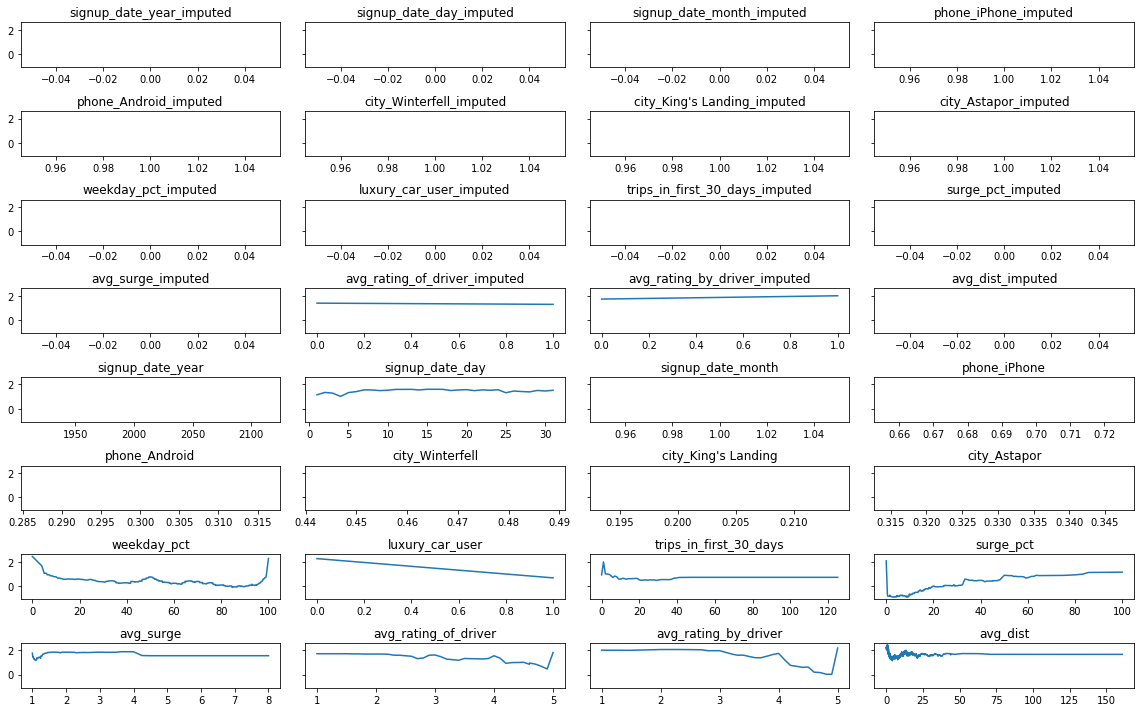

In [16]:
fig, axes = plt.subplots(8,4, figsize=(16,10), sharey=True)

for ax, feat_ind in zip(axes.flatten(), reversed(range(train_X.shape[1]))):
    xx, pdp = partial_dependence(rf, train_X.values, feat_ind, classification=True)
    ax.plot(xx, pdp)
    ax.set_title(train_X.columns[feat_ind])
plt.tight_layout()